In [2]:
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

%matplotlib notebook

In [3]:
def file_len(path):
    with gzip.open(path, 'rb') as f:
        for i, _ in enumerate(f):
            pass
    return i + 1

def get_initial_ordering(path="Data/ALL.chr22.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz"):
    """
    Returns initial ordering of patients in the database
    """
    with gzip.open(path, 'rb') as f:
        for i,l in enumerate(f):
            s = l.decode('utf-8')
            if i == 29:
                initial_order = pd.DataFrame(s.split()[9:])
                break
    return initial_order


class GenomeData:
    def __init__(self, name="chrom22", path="Data/22hap0.gz", verbose = True, test = False):
        self.name = name
        self.source_path = path if not test else "Data/22hap0_test.gz"
        self.verbose = verbose
        if self.verbose:
            print("Retrieving file length...")
        self.n_indiv = file_len(self.source_path)
        self.haploid0 = self.extract_data()
        self.haploid1, self.diploid = None, None
        self.ethnicity, self.initial_order, self.new_order = None, None, None

    def extract_data(self, path=None, verbose=None):
        if path is None:
            path=self.source_path
        if verbose is None:
            verbose=self.verbose
        if verbose:
            print("Extracting data from {}...".format(path))
        with gzip.open(path, 'rb') as f:
            for l in f:
                break
            s = l.decode('utf8')
            n = len(s.split())
            data = np.zeros((self.n_indiv,n), dtype=int)
            f.seek(0)
            for i,l in tqdm(enumerate(f), total=self.n_indiv):
                s = l.decode('utf8')
                data[i,] = np.array(list(map(float, s.split())))
        if verbose:
            print("\tdone.")
        return data
    
    def extract_labels(self, path="Data/ALL.chr22.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz"):
        if self.verbose:
            print("Extracting patient IDs...")
        with gzip.open(path, 'rb') as f:
            for i,l in enumerate(f):
                if i == 29:
                    s = l.decode('utf-8')
                    idList = s.split()[9:]
                    break
        self.index_to_id = idList
        self.id_to_index = {idList[i]:i for i in range(len(idList))}
    
    def extract_haploid1(self):
        if self.verbose:
            print("Extracting second haploid data...")
        self.haploid1 = self.extract_data(self.source_path.replace('0', '1'))
        
    def build_diploid(self):
        if self.verbose:
            print("Building diploid data...")
        self.diploid = self.haploid0 + self.haploid1
    
    def extract_ethnicity(self, path='Data/integrated_call_samples.20101123.ALL.panel'):
        data = pd.DataFrame(columns=['patient', 'country', 'continent'])
        with open(path, 'r') as f:
            for i,l in enumerate(f):
                info = l.strip().split()
                data.loc[i] = info[:3]
        self.ethnicity = data.set_index('patient').sort_values(by=['continent', 'country'], ascending=[False, True])
    
    def extract_ethnicity_index(self):
        if self.ethnicity is None:
            self.extract_ethnicity()
        ethnicity = self.ethnicity
        if self.initial_order is None:
            self.initial_order = get_initial_ordering()
        self.initial_order['index1'] = self.initial_order.index
        self.initial_order.set_index(0)
        self.new_order = ethnicity.join(self.initial_order.set_index(0), how='left').index1
    
    def apply(self, method, i, j):
        pass
        
    def get_name(self):
        return self.name
    
    def get_n_indiv(self):
        return self.n_indiv
        
    def get_haploid0(self, reorder=False):
        if self.new_order is None:
            self.extract_ethnicity_index()
            return self.haploid0[self.new_order]
        else:    
            return self.haploid0
    
    def get_haploid1(self, reorder=False):
        if self.haploid1 is None:
            self.extract_haploid1()
        if self.new_order is None:
            self.extract_ethnicity_index()
            return self.haploid1[self.new_order]
        else:
            return self.haploid1
    
    def get_diploid(self, reorder=False):
        if self.diploid is None:
            self.build_diploid()
        if self.new_order is None:
            self.extract_ethnicity_index()
            return self.diploid[self.new_order]
        else:
            return self.diploid
    

In [7]:
np.savetxt(fname="Data/22hap0_test.gz", X=test.haploid0[:,:10000])

In [3]:
pwd

'/home/vbillaut/Documents/Hash-based_patient_matching/Code'

In [9]:
test = GenomeData(test=True)

Retrieving file length...


  2%|▏         | 19/1092 [00:00<00:05, 189.10it/s]

Extracting data from Data/22hap0_test.gz...


100%|██████████| 1092/1092 [00:05<00:00, 204.92it/s]

	done.


In [4]:
genomedata = GenomeData()

Retrieving file length...


  0%|          | 0/1092 [00:00<?, ?it/s]

Extracting data from Data/22hap0.gz...


100%|██████████| 1092/1092 [05:07<00:00,  3.55it/s]

	done.


In [6]:
CE = ComparisonEngine(genomedata)

<IPython.core.display.Javascript object>


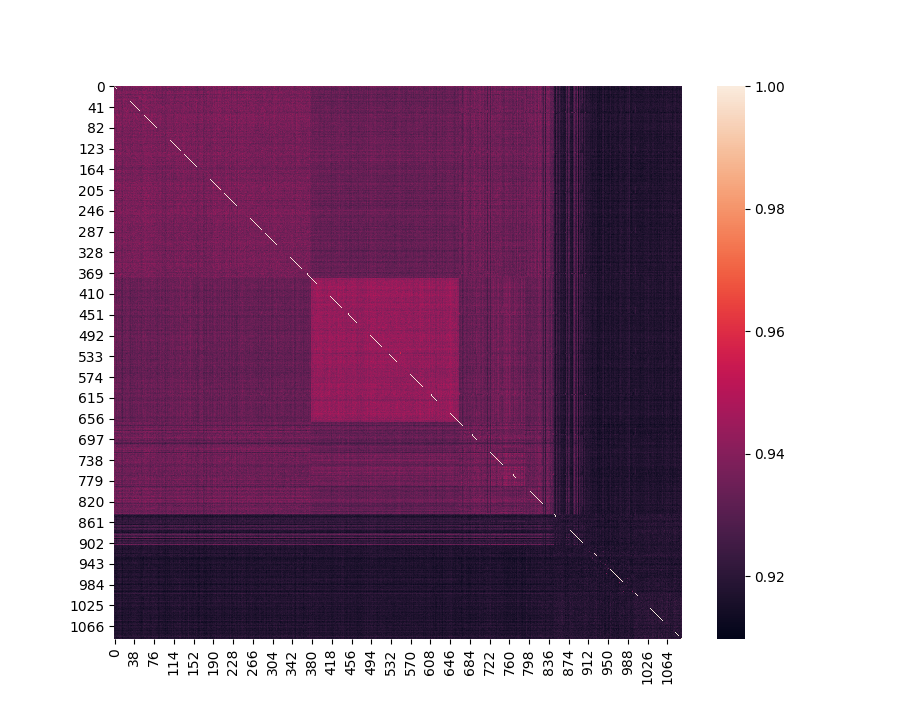

In [9]:
CE.heatmap()

In [11]:
np.unique(genomedata.ethnicity.continent)

array(['AFR', 'AMR', 'ASN', 'EUR'], dtype=object)

In [12]:
np.unique(genomedata.ethnicity.country)

array(['ASW', 'CEU', 'CHB', 'CHS', 'CLM', 'FIN', 'GBR', 'IBS', 'JPT',
       'LWK', 'MXL', 'PUR', 'TSI', 'YRI'], dtype=object)

---
### testing ethnicity reordering

In [4]:
def extractEthnicity(path='Data/integrated_call_samples.20101123.ALL.panel'):
    data = pd.DataFrame(columns=['patient', 'country', 'continent'])
    with open(path, 'r') as f:
        for i,l in enumerate(f):
            info = l.strip().split()
            data.loc[i] = info[:3]
    return data

In [13]:
ethnicity = extractEthnicity().set_index('patient').sort_values(by=['continent', 'country'], ascending=[False, True])

In [22]:
ethnicity

,country,continent
patient,,
NA06984,CEU,EUR
NA06986,CEU,EUR
NA06989,CEU,EUR
NA06994,CEU,EUR
NA07000,CEU,EUR
NA07037,CEU,EUR
NA07048,CEU,EUR
NA07051,CEU,EUR
NA07056,CEU,EUR


In [17]:
ethnicity.index

Index(['NA06984', 'NA06986', 'NA06989', 'NA06994', 'NA07000', 'NA07037',
       'NA07048', 'NA07051', 'NA07056', 'NA07347',
       ...
       'NA19213', 'NA19222', 'NA19223', 'NA19225', 'NA19235', 'NA19236',
       'NA19247', 'NA19248', 'NA19256', 'NA19257'],
      dtype='object', name='patient', length=1092)

In [16]:
ethnicity.shape

(1092, 2)

In [19]:
with gzip.open("Data/ALL.chr22.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz", 'rb') as f:
    for i,l in enumerate(f):
        s = l.decode('utf-8')
        if i == 29:
            initial_order = pd.DataFrame(s.split()[9:])
            break

In [31]:
initial_order['index1'] = initial_order.index

In [33]:
initial_order.set_index(0)

,index1
0,
HG00096,0
HG00097,1
HG00099,2
HG00100,3
HG00101,4
HG00102,5
HG00103,6
HG00104,7
HG00106,8


In [52]:
ethnicity.join(initial_order.set_index(0), how='left')

,country,continent,index1
patient,,,
NA06984,CEU,EUR,411
NA06986,CEU,EUR,412
NA06989,CEU,EUR,413
NA06994,CEU,EUR,414
NA07000,CEU,EUR,415
NA07037,CEU,EUR,416
NA07048,CEU,EUR,417
NA07051,CEU,EUR,418
NA07056,CEU,EUR,419


In [45]:
initial_order[initial_order[0]=='NA11920']

,0,index1
432,NA11920,432


In [46]:
ethnicity[ethnicity.index=='NA11920']

,country,continent
patient,,
NA11920,CEU,EUR


In [53]:
new_order = ethnicity.join(initial_order.set_index(0), how='left').index1

In [58]:
new_order

patient
NA06984    411
NA06986    412
NA06989    413
NA06994    414
NA07000    415
NA07037    416
NA07048    417
NA07051    418
NA07056    419
NA07347    420
NA07357    421
NA10847    422
NA10851    423
NA11829    424
NA11830    425
NA11831    426
NA11843    427
NA11892    428
NA11893    429
NA11894    430
NA11919    431
NA11920    432
NA11930    433
NA11931    434
NA11932    435
NA11933    436
NA11992    437
NA11993    438
NA11994    439
NA11995    440
          ... 
NA19137    748
NA19138    749
NA19146    750
NA19147    751
NA19149    752
NA19150    753
NA19152    754
NA19160    755
NA19171    756
NA19172    757
NA19175    758
NA19185    759
NA19189    760
NA19190    761
NA19197    762
NA19198    763
NA19200    764
NA19204    765
NA19207    766
NA19209    767
NA19213    768
NA19222    769
NA19223    770
NA19225    771
NA19235    772
NA19236    773
NA19247    774
NA19248    775
NA19256    776
NA19257    777
Name: index1, Length: 1092, dtype: int64

In [57]:
new_order.values

array([411, 412, 413, ..., 775, 776, 777])

In [74]:
CE.data[411,:150]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [75]:
CE.data[new_order.values][0,:150]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

---

In [5]:
import pickle
import os
import distance
from multiprocessing import Pool


class ComparisonEngine:
    def __init__(self, data=None, channel = 'hap0', window_size = 1, metric='similarity', 
                 option = '', ethnicity_reorder = True):
        self.genome_data = data
        self.channel = channel
        self.option = option
        self.metric_name = metric
        self.window_size = window_size
        self.ethnicity_reorder = ethnicity_reorder
        if self.genome_data is not None:
            self.get_data()
        self.set_metric(self.metric_name)
        self.cache_filename = None
        
    def get_data(self):
        if self.channel == 'hap0':
            self.data = self.genome_data.get_haploid0(reorder=self.ethnicity_reorder)
        elif self.channel == 'hap1':
            self.data = self.genome_data.get_haploid1(reorder=self.ethnicity_reorder)
        elif self.channel == 'dip':
            self.data = self.genome_data.get_diploid(reorder=self.ethnicity_reorder)
            
    def set_metric(self, metric):
        def hamming(x,y):
            return np.sum(np.abs(x-y))
        def similarity(x,y):
            d = hamming(x,y)
            return (len(x) + len(y) - d) * 1.0 / (len(x) + len(y) + d)
        if metric == 'hamming':
            self.metric = hamming
        if metric == 'similarity':
            self.metric = similarity
            
    def get_metric(self):
        return self.metric
            
    def init_filename(self):
        if not os.path.exists('Data/cache/'):
            os.mkdir('Data/cache/')
        self.cache_filename = 'Data/cache/{}_{}_{}_{}{}_{}.pkl'.format(self.genome_data.get_name(),
#                                                                   self.genome_data.name,
                                                                  self.channel,
                                                                  self.metric_name,
                                                                  self.window_size,
                                                                  "_reorder" if self.ethnicity_reorder else "",
                                                                  self.option)
        
    def load_from_cache(self):
        if self.cache_filename is None:
            self.init_filename()
        result = pickle.load(open(self.cache_filename, 'rb'))
        return result
    
    def dump_to_cache(self, data):
        if self.cache_filename is None:
            self.init_filename()
        pickle.dump(data, open(self.cache_filename, 'wb'))
    
    def compute(self):
        n = self.genome_data.get_n_indiv()
#         n = self.genome_data.n_indiv
        matrix = np.zeros((n, n))
        test = np.array([0])
        for i in range(n):
            matrix[i,i] = self.metric(test, test)
        
        def compute_row(i):
            res = []
            for j in range(i+1,n):
                res.append(self.metric(self.data[i,], self.data[j,]))
            return res
        
#         pool = Pool(8)
#         results = pool.map(compute_row, list(range(n-1)))
#         pool.close()
#         pool.join()

        results = []
        for i in tqdm(range(n-1)):
            results.append(compute_row(i))
        
        for i in range(n-1):
            matrix[i+1:,i] = np.array(results[i])
            matrix[i,i+1:] = np.array(results[i])
            
        return matrix
    
    def compute_individual(self, i):
        pass
    
    def apply(self, force_recompute = False, force_dump = True):
        if not force_recompute:
            try:
                return self.load_from_cache()
            except:
                result = self.compute()
                if force_dump:
                    self.dump_to_cache(result)
                return result
        else:
            result = self.compute()
            if force_dump:
                self.dump_to_cache(result)
            return result
        
    def heatmap(self, **args):
        sns.heatmap(self.load_from_cache(), **args)
        plt.show()

In [41]:
CE = ComparisonEngine(test, option='test')

In [42]:
CE.data.shape

(1092, 10000)

In [43]:
CE.apply()#force_recompute=True)

100%|██████████| 1091/1091 [00:44<00:00, 24.66it/s]


array([[ 1.        ,  0.90921674,  0.92252235, ...,  0.92613281,
         0.92113731,  0.91350938],
       [ 0.90921674,  1.        ,  0.9043085 , ...,  0.95198126,
         0.90403656,  0.92687509],
       [ 0.92252235,  0.9043085 ,  1.        , ...,  0.91451682,
         0.92169109,  0.89519568],
       ..., 
       [ 0.92613281,  0.95198126,  0.91451682, ...,  1.        ,
         0.91607588,  0.93208714],
       [ 0.92113731,  0.90403656,  0.92169109, ...,  0.91607588,
         1.        ,  0.900689  ],
       [ 0.91350938,  0.92687509,  0.89519568, ...,  0.93208714,
         0.900689  ,  1.        ]])

In [45]:
ls Data/cache/

chrom22_hap0_similarity_1_reorder_test.pkl  chrom22_similarity_1_reorder_.pkl
chrom22_similarity_1_.pkl                   chrom22_similarity_1_test.pkl


---
### benchmark distances

In [49]:
%time print([distance.hamming((np.random.random(200)>0.5), (np.random.random(200)>0.5)) for _ in range(10000)][:5])

[106, 96, 89, 99, 116]
CPU times: user 10.6 s, sys: 404 ms, total: 11 s
Wall time: 9.56 s


In [50]:
%time print([np.sum(np.abs((np.random.random(200)>0.5) != (np.random.random(200)>0.5))) for _ in range(10000)][:5])

[95, 108, 95, 103, 95]
CPU times: user 328 ms, sys: 40 ms, total: 368 ms
Wall time: 365 ms


`distance.hamming` is super slow, we need to use `numpy` instead.

---

### heatmap tests

In [46]:
matrix = CE.apply()

In [47]:
matrix.shape

(1092, 1092)

In [50]:
CE.cache_filename

'Data/cache/chrom22_hap0_similarity_1_reorder_test.pkl'

<IPython.core.display.Javascript object>


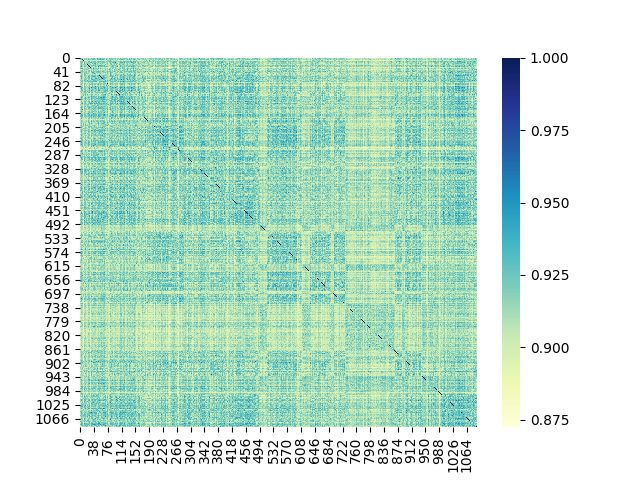

In [49]:
CE.heatmap(cmap="YlGnBu")

---

---
### ethnicity reordering tests

In [10]:
test.haploid0[:5, :30]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]])

In [11]:
reordered_hap = test.get_haploid0(reorder=True)

In [18]:
reordered_hap[:5, :50]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])

In [14]:
test.new_order[:5]

patient
NA06984    411
NA06986    412
NA06989    413
NA06994    414
NA07000    415
Name: index1, dtype: int64

In [19]:
test.haploid0[[411,412,413,414,415], :50]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])

---